In [21]:
import os
import pandas as pd
import pickle
from scipy.signal import welch, butter, filtfilt
from scipy.integrate import simpson
import scipy.stats as stats
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Serialize and Unserialize RAW data

In [2]:
column_names = [
    "Sample Index",
    "EEG Channel 0", "EEG Channel 1", "EEG Channel 2", "EEG Channel 3",
    "EEG Channel 4", "EEG Channel 5", "EEG Channel 6", "EEG Channel 7",
    "Accelerometer X", "Accelerometer Y", "Accelerometer Z",
    "Timestamp", "Timestamp (Formatted)"
]

# Walk through Data files, create dataframes, and pickle them
for root, dirs, files in os.walk('./Data'):
    for file in files:
        if file.endswith(".csv"):
            csv_path = os.path.join(root, file)
            relative_path = os.path.relpath(csv_path, './Data')
            pkl_path = os.path.join('./Data', relative_path).replace(".csv", ".pickle")

            os.makedirs(os.path.dirname(pkl_path), exist_ok=True)

            try:
                df = pd.read_csv(csv_path, sep='\t', header=None)
                # Just grab the first twelve and second to last columns
                df_filtered = df[list(df.columns[:12]) + [df.columns[-2]]].copy()
                # Create a new column with formatted timestamps
                df_filtered["Timestamp (Formatted)"] = pd.to_datetime(df_filtered.iloc[:, -1], unit='s', utc=True)
                # And update the column names
                df_filtered.columns = column_names
                # And cut off the first row
                df_filtered = df_filtered[1:].copy()
                # Finally, pickle the dataframe
                df_filtered.to_pickle(pkl_path)
            except Exception as e:
                print(f"Error processing {csv_path}: {e}")

In [3]:
# From pickles, create one large 'data' dataframe
# Structure: data[participant][category][Optional[task]][Optional[subtask]]
#   ex. data[1][Baselines]
#   ex. data[1][Rhythm][Karate]
#   ex. data[1][Reading][English][In]
data = {}

for root, _, files in os.walk('./Data'):
    for file in files:
        if file.endswith(".pickle") and root != './Data':
            filepath = os.path.join(root, file)
            parts = filepath.split(os.sep)
            df = pd.read_pickle(filepath)

            participant = parts[-2]
            category = parts[2]
            if category != 'Baselines':
                task = parts[3]
                if len(parts) > 6:
                    data.setdefault(participant, {}).setdefault(category, {}).setdefault(task, {})[parts[4]] = df
                else:
                    data.setdefault(participant, {}).setdefault(category, {})[task] = df
            else:
                data.setdefault(participant, {})[category] = df

with open('./Data/all_data_RAW.pickle', 'wb') as fp:
    pickle.dump(data, fp)

# Scale data up
# scale_factor = 4.5 / 24 / (2**23 - 1) * 1e6

# for participant in data:
#     for category in data[participant]:
#         category_data = data[participant][category]

#         if isinstance(category_data, dict):
#             for task in category_data:
#                 task_data = category_data[task]

#                 if isinstance(task_data, dict):
#                     for subtask in task_data:
#                         df = task_data[subtask]
#                         for ch in range(8):
#                             col = f"EEG Channel {ch}"
#                             df[col] = df[col] * scale_factor
#                 else:
#                     df = task_data
#                     for ch in range(8):
#                         col = f"EEG Channel {ch}"
#                         df[col] = df[col] * scale_factor
#         else:
#             df = category_data
#             for ch in range(8):
#                 col = f"EEG Channel {ch}"
#                 df[col] = df[col] * scale_factor

# with open('./Data/all_data_SCALED.pickle', 'ab') as fp:
#     pickle.dump(data, fp)
# with open('./Data/all_data_RAW.pickle', 'rb') as fp:
#     raw_data = pickle.load(fp)

# Serialize and Unserialize FILTERED data

In [4]:
def plot_data(data, title, path):
    fig, axs = plt.subplots(8, 1, figsize=(12, 10), sharex=True)
    fig.suptitle(title, fontsize=16)

    colors = ['#afb6be', '#7c4b8d', '#36579e', '#317159', '#ddb20d', '#fd5e34', '#e0382d', '#a25231']
    for i, channel in enumerate([f"EEG Channel {i}" for i in range(8)]):
        axs[i].plot(data[channel], linewidth=1, color=colors[i])
        axs[i].set_ylabel(f"Channel {i}")
        axs[i].set_yticklabels([])
        axs[i].set_yticks([])
        axs[i].set_xticks([])

    plt.tight_layout(pad=0.5, h_pad=0)
    plt.subplots_adjust(top=0.95)
    plt.savefig(path)
    plt.close()


b, a = butter(2, (0.1, 70.1), 'bandpass', fs=250)
def filter_df(df):
    for ch in [f"EEG Channel {i}" for i in range(8)]:
        df[ch] = filtfilt(b, a, df[ch])
    return df


data_filtered = {}
for participant in data:
    data_filtered[participant] = {}
    for task in data[participant]:
        if task == 'Baselines':
            df = data[participant][task]
            df_filtered = filter_df(df.copy())
            data_filtered[participant][task] = df_filtered
            plot_data(df_filtered, f'Participant no. {participant}: {task}', f'./Data/{task}/{participant}/{participant}_filtered.png')
        else:
            data_filtered[participant][task] = {}
            for subtask in data[participant][task]:
                if task == 'Reading':
                    data_filtered[participant][task][subtask] = {}
                    for direction in data[participant][task][subtask]:
                        df = data[participant][task][subtask][direction]
                        df_filtered = filter_df(df.copy())
                        data_filtered[participant][task][subtask][direction] = df_filtered
                        plot_data(df_filtered, f'Participant no. {participant}: {task}, {subtask} ({direction})', f'./Data/{task}/{subtask}/{direction}/{participant}/{participant}_filtered.png')
                else:
                    df = data[participant][task][subtask]
                    df_filtered = filter_df(df.copy())
                    data_filtered[participant][task][subtask] = df_filtered
                    plot_data(df_filtered, f'Participant no. {participant}: {task}, {subtask}', f'./Data/{task}/{subtask}/{participant}/{participant}_filtered.png')

with open('./Data/all_data_FILTERED.pickle', 'wb') as fp:
    pickle.dump(data_filtered, fp)

In [5]:
with open('./Data/all_data_FILTERED.pickle', 'rb') as fp:
    data_filtered = pickle.load(fp)

# Serialize and Unserialize Welch bandpower data

In [6]:
bands = [
    (0, 4, "Delta", "#e0382d"),
    (4, 8, "Theta", "#ddb20d"),
    (8, 10, "Alpha", "#317159"),
    (10, 13, "Mu", "#358a9e"),
    (13, 20, "Beta I", "#36579e"),
    (20, 50, "Beta II", "#48359e"),
    (50, 125, "Gamma", "#7c4b8d"),
]
def plot_welch(df, title, path):
    """ Welch Power Spectral Density """
    channels = [f"EEG Channel {i}" for i in range(8)]
    bandpowers = {ch: {} for ch in channels}
    fig, axs = plt.subplots(4, 2, figsize=(14, 10), sharex=True, sharey=True)
    axs = axs.flatten()

    for i, channel in enumerate(channels):
        freqs, power = welch(df[channel], fs=250, nperseg=1280)

        axs[i].semilogy(freqs, power, color='white')
        axs[i].set_title(f"{channel} Welch")
        axs[i].set_xlim([0, 80])
        axs[i].set_xticks([])
        axs[i].set_yticklabels([])
        axs[i].set_yticks([])
        axs[i].grid(True)
        
        for j, (low, high, label, color) in enumerate(bands):
            if high > 125:
                continue
            axs[i].axvspan(low, high, color=color, alpha=0.75, label=label)

            band_mask = (freqs >= low) & (freqs <= high)
            if np.any(band_mask):
                band_freqs = freqs[band_mask]
                band_power = power[band_mask]
                peak_idx = np.argmax(band_power)
                peak_freq = band_freqs[peak_idx]
                peak_pow = band_power[peak_idx]

                bandpowers[channel][label] = simpson(power[band_mask], freqs[band_mask])

                xoffset = 5 if j == 6 or j == 0 else 0
                yoffset = 10 if j == 0 else 0.001 if j % 2 == 1 or j == 6 else 30

                axs[i].annotate(f"{peak_freq:.1f} Hz",
                                xy=(peak_freq, peak_pow),
                                xytext=(peak_freq + xoffset, peak_pow * yoffset),
                                arrowprops=dict(arrowstyle="->", lw=0.8),
                                fontsize=8, ha='center')

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, ncol=7, fontsize='small', bbox_to_anchor=(0.7225, 0.9575))
    plt.suptitle(f"Welch Power Spectral Density - {title}", fontsize=16)
    fig.text(0.5, 0.01, 'Frequency (Hz)', ha='center', fontsize=12)
    fig.text(0.01, 0.5, 'Power (μV²/Hz)', va='center', rotation='vertical', fontsize=12)
    plt.tight_layout(pad=0.5, w_pad=1)
    plt.subplots_adjust(top=0.89, left=0.03, bottom=0.035)
    plt.savefig(path)
    plt.close()

    return bandpowers

data_bandpowers = {}
for participant in data_filtered:
    data_bandpowers[participant] = {}
    for task in data_filtered[participant]:
        if task == 'Baselines':
            df = data_filtered[participant][task].copy()
            data_bandpowers[participant][task] = plot_welch(df, f'Participant no. {participant}: {task}', f'./Data/{task}/{participant}/{participant}_Welch.png')
        else:
            data_bandpowers[participant][task] = {}
            for subtask in data_filtered[participant][task]:
                if task == 'Reading':
                    data_bandpowers[participant][task][subtask] = {}
                    for direction in data_filtered[participant][task][subtask]:
                        df = data_filtered[participant][task][subtask][direction].copy()
                        data_bandpowers[participant][task][subtask][direction] = plot_welch(df, f'Participant no. {participant}: {task}, {subtask} ({direction})', f'./Data/{task}/{subtask}/{direction}/{participant}/{participant}_Welch.png')
                else:
                    df = data_filtered[participant][task][subtask].copy()
                    data_bandpowers[participant][task][subtask] = plot_welch(df, f'Participant no. {participant}: {task}, {subtask}', f'./Data/{task}/{subtask}/{participant}/{participant}_Welch.png')

with open('./Data/all_data_BANDPOWERS.pickle', 'wb') as fp:
    pickle.dump(data_bandpowers, fp)

In [7]:
with open('./Data/all_data_BANDPOWERS.pickle', 'rb') as fp:
    data_bandpowers = pickle.load(fp)

# Univariate One-Way Repeated Measures ANOVA with Tukey post-hoc
F([DoF1], [DoF2]) = [p Value], p < [0.05, 0.01, or 0.001]

In [8]:
rows = []
for participant in data_bandpowers:
    for task in data_bandpowers[participant]:
        if task == 'Baselines':
            bandpowers = data_bandpowers[participant][task]
            for channel in bandpowers:
                for band in bandpowers[channel]:
                    rows.append({
                        "Participant": participant,
                        "Task": task,
                        "Channel": channel,
                        "Band": band,
                        "Power": bandpowers[channel][band]
                    })
        else:
            for subtask in data_bandpowers[participant][task]:
                if task == 'Reading':
                    for direction in data_bandpowers[participant][task][subtask]:
                        bandpowers = data_bandpowers[participant][task][subtask][direction]
                        for channel in bandpowers:
                            for band in bandpowers[channel]:
                                rows.append({
                                    "Participant": participant,
                                    "Task": ' '.join([task, subtask, direction]),
                                    "Channel": channel,
                                    "Band": band,
                                    "Power": bandpowers[channel][band]
                                })
                else:
                    if subtask == 'Sheet Music': continue
                    bandpowers = data_bandpowers[participant][task][subtask]
                    for channel in bandpowers:
                        for band in bandpowers[channel]:
                            rows.append({
                                "Participant": participant,
                                "Task": ' '.join([task, subtask]),
                                "Channel": channel,
                                "Band": band,
                                "Power": bandpowers[channel][band]
                            })

bandpower_df = pd.DataFrame(rows)
print(bandpower_df)

     Participant                 Task        Channel     Band         Power
0              0  Reading English Out  EEG Channel 0    Delta  4.584478e+04
1              0  Reading English Out  EEG Channel 0    Theta  1.446871e+03
2              0  Reading English Out  EEG Channel 0    Alpha  3.864124e+02
3              0  Reading English Out  EEG Channel 0       Mu  2.541194e+02
4              0  Reading English Out  EEG Channel 0   Beta I  3.942462e+02
...          ...                  ...            ...      ...           ...
2459           2       Writing French  EEG Channel 7    Alpha  4.434485e+00
2460           2       Writing French  EEG Channel 7       Mu  4.856492e+00
2461           2       Writing French  EEG Channel 7   Beta I  1.187034e+01
2462           2       Writing French  EEG Channel 7  Beta II  2.151978e+01
2463           2       Writing French  EEG Channel 7    Gamma  2.117232e+07

[2464 rows x 5 columns]


In [9]:
anova_results = []
tukey_results = []
for band in ['Delta', 'Theta', 'Alpha', 'Mu', 'Beta I', 'Beta II', 'Gamma']:
    for ch in [f"EEG Channel {i}" for i in range(8)]:
        band_df = bandpower_df[
            (bandpower_df['Band'] == band) &
            (bandpower_df['Channel'] == ch)
        ].copy()

        anova_result = pg.rm_anova(
            data=band_df,
            dv='Power',
            within='Task',
            subject='Participant',
            # detailed=True
        )

        anova_results.append({
            'Channel': ch,
            'Band': band,
            'F Value': anova_result['F'][0],
            'DoF1': anova_result['ddof1'][0],
            'DoF2': anova_result['ddof2'][0],
            'p Value': anova_result['p-unc'][0],
            'Generalized n^2': anova_result['ng2'][0]
        })

        tukey_result = pg.pairwise_tukey(
            data=band_df,
            dv='Power',
            between='Task'
        )
        # print(tukey_result)

        # tukey_results.append({

        # })

anova_results = pd.DataFrame(anova_results)

In [10]:
# p-value should be:
#   < 0.05  : good
#   < 0.01  : great
#   < 0.001 : ideal
print(anova_results[anova_results['p Value'] < 0.05])
# eta-squared should be:
#   0.01 : small effect size
#   0.06 : medium effect size
#   0.14 : large effect size
# print(anova_results[anova_results['Generalized n^2'] > 0.14])

          Channel     Band   F Value  DoF1  DoF2   p Value  Generalized n^2
36  EEG Channel 4   Beta I  3.011294    10    30  0.009399         0.445778
37  EEG Channel 5   Beta I  2.677320    10    30  0.018001         0.445282
44  EEG Channel 4  Beta II  3.334207    10    30  0.005092         0.515670
45  EEG Channel 5  Beta II  2.187801    10    30  0.047721         0.392048


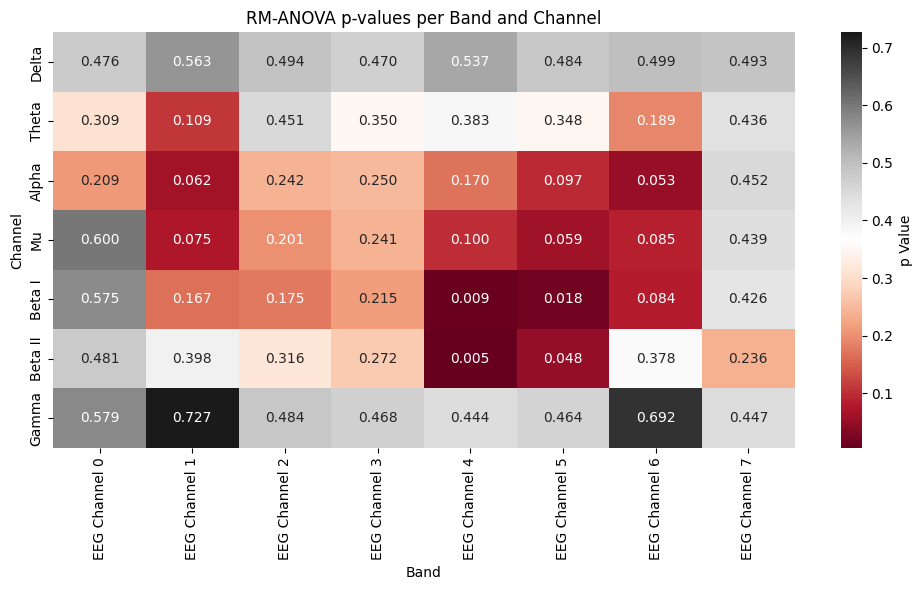

In [15]:
anova_results_pivoted = anova_results.pivot(index="Band", columns="Channel", values="p Value").loc[['Delta', 'Theta', 'Alpha', 'Mu', 'Beta I', 'Beta II', 'Gamma']]

plt.figure(figsize=(10, 6))
sns.heatmap(anova_results_pivoted, annot=True, fmt=".3f", cmap="RdGy", cbar_kws={"label": "p Value"})
plt.title("RM-ANOVA p-values per Band and Channel")
plt.ylabel("Channel")
plt.xlabel("Band")
plt.tight_layout()
plt.savefig('./Data/RM-ANOVA_pValue_heatmap')
plt.show()

# Paired t-test

In [48]:
ttest_results = []
for band in ['Delta', 'Theta', 'Alpha', 'Mu', 'Beta I', 'Beta II', 'Gamma']:
    for ch in [f"EEG Channel {i}" for i in range(8)]:
        for eng_task, fr_task in [
            ("Reading English In", "Reading French In"),
            ("Reading English Out", "Reading French Out"),
            ("Speaking English", "Speaking French"),
            ("Writing English", "Writing French"),
        ]:
            df_eng = bandpower_df[
                (bandpower_df["Band"] == band) &
                (bandpower_df["Channel"] == ch) &
                (bandpower_df["Task"] == eng_task)
            ][["Participant", "Power"]].rename(columns={"Power": "Power_en"})
            df_fr = bandpower_df[
                (bandpower_df["Band"] == band) &
                (bandpower_df["Channel"] == ch) &
                (bandpower_df["Task"] == fr_task)
            ][["Participant", "Power"]].rename(columns={"Power": "Power_fr"})
            df_merged = pd.merge(df_eng, df_fr, on="Participant")

            result = pg.ttest(
                df_merged["Power_en"],
                df_merged["Power_fr"],
                paired=True,
                alternative='two-sided'
            )

            ttest_results.append({
                "Band": band,
                "Channel": ch,
                "Task": eng_task.replace(' English', ''),
                "DoF": result['dof'][0],
                "T": result['T'][0],
                "p Value": result['p-val'][0],
                "Cohen d": result['cohen-d'][0]
            })

ttest_df = pd.DataFrame(ttest_results)
ttest_df = ttest_df.sort_values("p Value")

/var/folders/kt/rq_fnm7978g0m_s5fz41mb3c0000gn/T/ipykernel_35787/1994901704.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "DoF": result['dof'][0],
/var/folders/kt/rq_fnm7978g0m_s5fz41mb3c0000gn/T/ipykernel_35787/1994901704.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "T": result['T'][0],
/var/folders/kt/rq_fnm7978g0m_s5fz41mb3c0000gn/T/ipykernel_35787/1994901704.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "p 

In [44]:
# p-value should be:
#   < 0.05  : good
#   < 0.01  : great
#   < 0.001 : ideal
print(ttest_df[ttest_df['p Value'] < 0.05])

        Band        Channel       Task  DoF         T   p Value   Cohen d
154   Beta I  EEG Channel 6  Speaking     3 -6.746462  0.006651  0.628953
110       Mu  EEG Channel 3  Speaking     3 -4.479304  0.020746  1.749550
182  Beta II  EEG Channel 5  Speaking     3 -3.298804  0.045775  0.070676


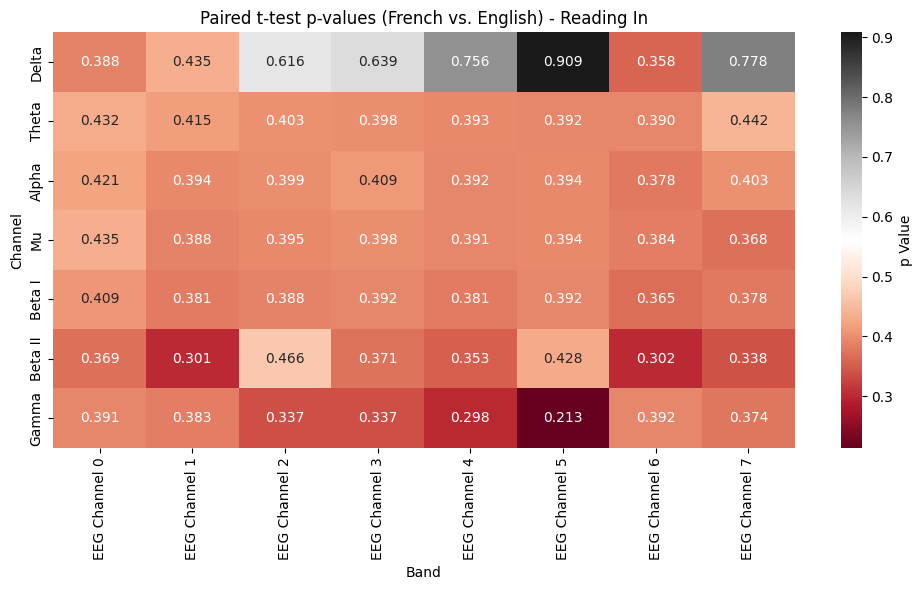

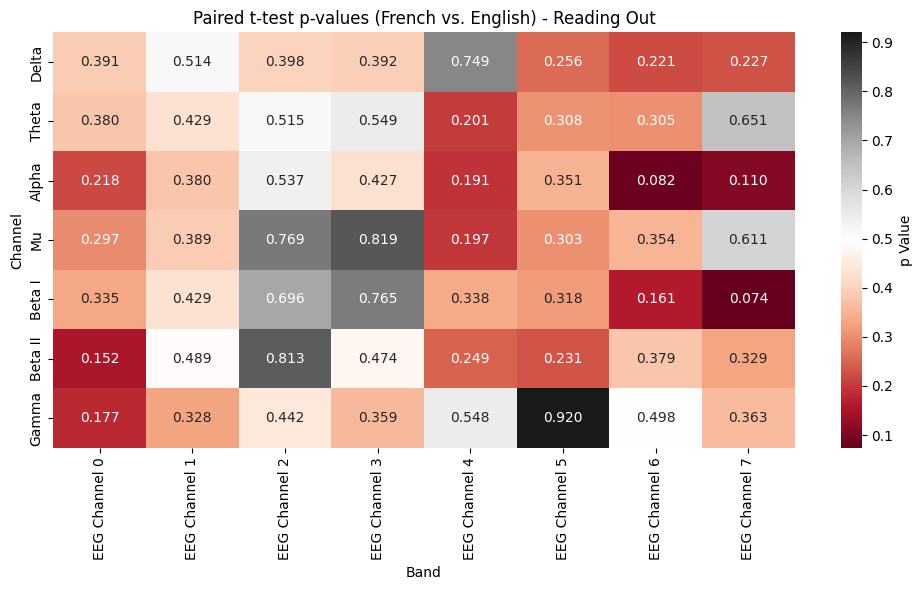

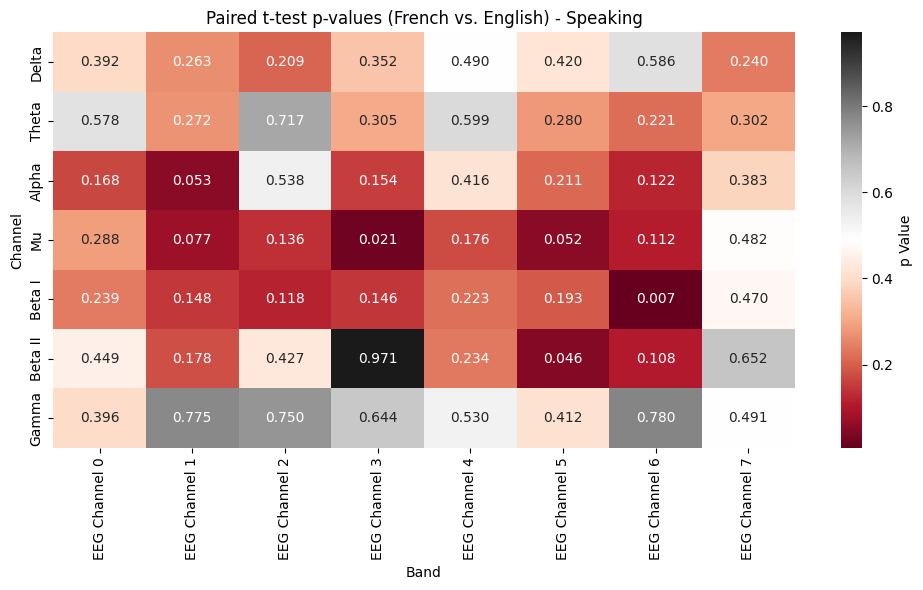

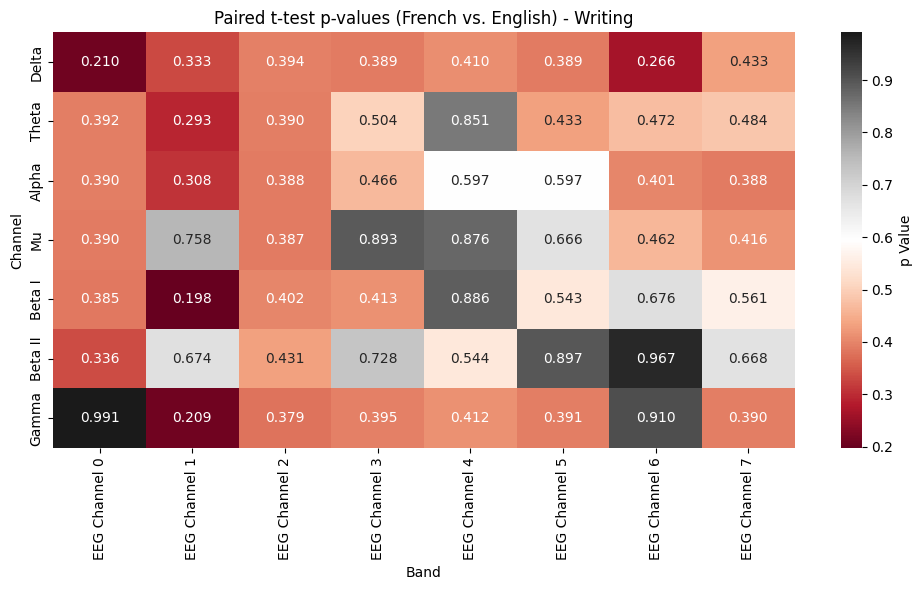

In [51]:
for task in ['Reading In', 'Reading Out', 'Speaking', 'Writing']:
    ttest_df_pivoted = ttest_df[ttest_df["Task"] == task].pivot(index="Band", columns="Channel", values="p Value").loc[['Delta', 'Theta', 'Alpha', 'Mu', 'Beta I', 'Beta II', 'Gamma']]

    plt.figure(figsize=(10, 6))
    sns.heatmap(ttest_df_pivoted, annot=True, fmt=".3f", cmap="RdGy", cbar_kws={"label": "p Value"})
    plt.title(f"Paired t-test p-values (French vs. English) - {task}")
    plt.ylabel("Channel")
    plt.xlabel("Band")
    plt.tight_layout()
    if len(task := task.split()) > 1:
        plt.savefig(f'./Data/{task[0]}/({task[1]})paired_ttest_pValue_heatmap')
    else:
        plt.savefig(f'./Data/{task[0]}/paired_ttest_pValue_heatmap')
    plt.show()

# Other Stuff

In [59]:
summary_df = (
    bandpower_df
    .groupby(["Band", "Task", "Channel"])
    .agg(
        Mean_Power=("Power", "mean"),
        Std_Dev=("Power", "std")
    )
    .reset_index()
)

summary_df[
    ((summary_df['Band'] == 'Beta I') &
    ((summary_df['Channel'] == 'EEG Channel 4') |
    (summary_df['Channel'] == 'EEG Channel 5') |
    (summary_df['Channel'] == 'EEG Channel 6'))) |
    ((summary_df['Band'] == 'Mu') &
    (summary_df['Channel'] == 'EEG Channel 3')) |
    ((summary_df['Band'] == 'Beta II') &
    ((summary_df['Channel'] == 'EEG Channel 4') |
    (summary_df['Channel'] == 'EEG Channel 5')))
]

,Band,Task,Channel,Mean_Power,Std_Dev
92,Beta I,Baselines,EEG Channel 4,10.361921,4.340996
93,Beta I,Baselines,EEG Channel 5,11.153790,4.454905
94,Beta I,Baselines,EEG Channel 6,27.566239,23.942265
100,Beta I,Reading English In,EEG Channel 4,165.788231,308.778948
101,Beta I,Reading English In,EEG Channel 5,165.039387,305.970964
...,...,...,...,...,...
491,Mu,Rhythm Tutorial,EEG Channel 3,1120.150128,1719.468846
499,Mu,Speaking English,EEG Channel 3,13.443245,8.534718
507,Mu,Speaking French,EEG Channel 3,31.949399,12.285459
515,Mu,Writing English,EEG Channel 3,23.920605,15.732657


In [ ]:
anova_results = []
for band in ['Delta', 'Theta', 'Alpha', 'Mu', 'Beta I', 'Beta II', 'Gamma']:
    for ch in [f"EEG Channel {i}" for i in range(8)]:
        band_df = bandpower_df[
            (bandpower_df['Band'] == band) &
            (bandpower_df['Channel'] == ch)
        ]

        result = AnovaRM(
            band_df,
            depvar='Power',
            subject='Participant',
            within=['Task']
        ).fit().anova_table.loc['Task']

        anova_results.append({
            'Band': band,
            'Channel': ch,
            'F Value': result['F Value'],
            'Num DF': result['Num DF'],
            'Den DF': result['Den DF'],
            'Pr > F': result['Pr > F']
        })

anova_results = pd.DataFrame(anova_results)